In [33]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import metrics
from IPython.lib.pretty import pretty
import pandas as pd

### **Task 1: Multivariate Gaussian Classifier**

Using Fisheriris multivariate data (you already have it in .mat file), perform 
multivariate Gaussian classification. This is a 4D data with three classes and the corresponding labels.
1. Randomly shuffle the data and corresponding labels.
2. Use first 100 samples (rows) in training dataset.
3. Use remaining 50 samples in test dataset.
4. Scatter plot first two dimensions of each class.
5. Using Gaussian discriminant function without dropping any term, perform 
classification and show the result in a form of a confusion matrix.
6. Can you drop any term in the discriminant function? Why?


In [34]:
# Plotting settings: STIX fonts
plt.rcParams["font.family"] = "STIXGeneral"

# Loading data
data = loadmat("iris_data.mat")["iris"]  # 150x5
features = data[:, :-1]  # 150x4
labels = data[:, -1]  # 150x1
split_val = 100  # 100 for training, len(data) - 100 for testing

# Class labels
class_names = [
    "Setosa",
    "Versicolor",
    "Virginica",
]  # Ref: https://en.wikipedia.org/wiki/Iris_flower_data_set
class_ids = np.unique(labels).astype(int)  # 0, 1, 2

print("Data shape:", data.shape)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print("Class labels:", class_names)
print("Class IDs:", class_ids)

Data shape: (150, 5)
Features shape: (150, 4)
Labels shape: (150,)
Class labels: ['Setosa', 'Versicolor', 'Virginica']
Class IDs: [1 2 3]


**Randomly shuffle the data and corresponding labels.**

In [35]:
m = len(data)  # Number of samples
indices = np.random.permutation(m)  # Create a list of shuffled indices from 0 to m-1
X = features[indices]  # Shuffle the dataset
y = labels[indices]  # Shuffle the labels

**Use first 100 samples (rows) in training dataset.**

In [36]:
# Split the dataset into training and test datasets
X_train = X[: split_val]
y_train = y[: split_val]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (100, 4)
y_train shape: (100,)


**Use remaining 50 samples in test dataset.**

In [37]:
X_test = X[split_val :]
y_test = y[split_val :]

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (50, 4)
y_test shape: (50,)


**Scatter plot of first two dimensions.**

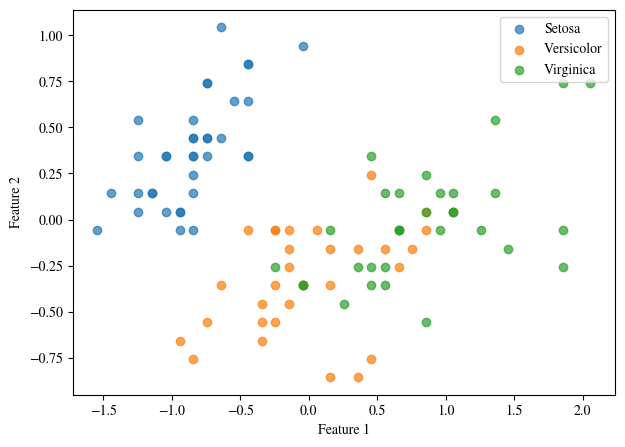

In [38]:
plt.figure(figsize=(7, 5))
for i in class_ids:
    plt.scatter(
        X_train[y_train == i, 0],
        X_train[y_train == i, 1],
        label=class_names[i - 1],
        alpha=0.7,
    )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.savefig("scatter_plot.pdf", bbox_inches="tight", dpi=300)
plt.show()

**Using Gaussian discriminant function without dropping any term, perform classification and show the result in a form of a confusion matrix.**

The Gaussian discriminant function is given by
$$ g_i(\mathbf{x}) = -\frac{1}{2}(\mathbf{x}-\mathbf{m}_i)^T\mathbf{S}_i^{-1}(\mathbf{x}-\mathbf{m}_i) - \frac{1}{2}\ln|\mathbf{S}_i| + \ln \hat{P}(C_i),$$

where $\mathbf{m}_i$ and $\mathbf{S}_i$ are the estimates of the mean and covariance matrix of the data in each class $C_i$.

Priors:
 {1: 0.36, 2: 0.32, 3: 0.32}

Means:
 {1: array([-0.85444444,  0.37322222, -2.28855556, -0.96044444]),
 2: array([ 0.01916667, -0.31983333,  0.46075   ,  0.10691667]),
 3: array([ 0.83791667, -0.02608333,  1.82325   ,  0.82879167])}

Covariances:
 {1: array([[0.09930159, 0.06177778, 0.01307937, 0.00873016],
        [0.06177778, 0.08561111, 0.00524603, 0.00849206],
        [0.01307937, 0.00524603, 0.03589683, 0.00522222],
        [0.00873016, 0.00849206, 0.00522222, 0.01044444]]),
 2: array([[0.26048387, 0.06306452, 0.19072581, 0.05959677],
        [0.06306452, 0.08177419, 0.07862903, 0.03653226],
        [0.19072581, 0.07862903, 0.24092742, 0.08278226],
        [0.05959677, 0.03653226, 0.08278226, 0.04254032]]),
 3: array([[0.33641129, 0.10350806, 0.25770161, 0.05086694],
        [0.10350806, 0.09899194, 0.07770161, 0.04747984],
        [0.25770161, 0.07770161, 0.27060484, 0.03764113],
        [0.05086694, 0.04747984, 0.03764113, 0.06595766]])}
y_pred:
 [3. 1. 3. 3. 2. 1. 1. 3.

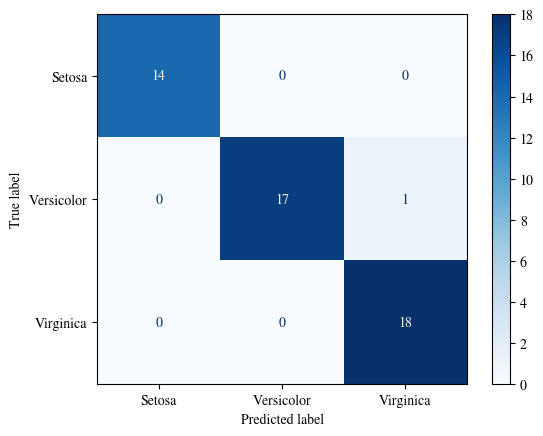

In [39]:
# Estimating parameters
priors = dict()
means = dict()
covs = dict()

for i in class_ids:
    priors[i] = np.sum(y_train == i) / len(y_train)
    means[i] = np.mean(X_train[y_train == i], axis=0)  # each mean vector is 1x4
    covs[i] = np.cov(X_train[y_train == i].T)  # each cov mat is 4x4

print("Priors:\n", pretty(priors))
print("\nMeans:\n", pretty(means))
print("\nCovariances:\n", pretty(covs))


def discriminant_function(x, i):
    """Gaussian discriminant function"""
    return (
        -0.5 * np.log(np.linalg.det(covs[i]))
        - 0.5 * (x - means[i]).T @ np.linalg.inv(covs[i]) @ (x - means[i])
        + np.log(priors[i])
    )


# Testing
y_pred = np.zeros(len(y_test))

for i in range(len(y_test)):
    x = X_test[i]
    g = np.zeros(len(class_ids))
    for j in class_ids:
        g[j - 1] = discriminant_function(x, j)
    y_pred[i] = np.argmax(g) + 1  # +1 because class_ids start from 1

print("y_pred:\n", y_pred)
print("\ny_test:\n", y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_display.plot(cmap=plt.cm.Blues)
plt.savefig("confusion_matrix.pdf", bbox_inches="tight", dpi=300)
plt.show()

**Can you drop any term in the discriminant function? Why?**

Yes, we can drop the prior probability term in the discriminant function. This is because the prior probability is the nearly the same for all the classes, i.e., Fisher's Iris is a balanced dataset. Hence, the prior probability term will not affect the classification results.

y_pred:
 [3. 1. 3. 3. 2. 1. 1. 3. 2. 2. 3. 2. 3. 1. 2. 3. 3. 3. 3. 2. 3. 1. 2. 2.
 2. 2. 1. 1. 2. 1. 3. 2. 1. 1. 3. 2. 3. 3. 3. 1. 3. 2. 1. 2. 1. 1. 2. 3.
 3. 2.]

y_test:
 [3. 1. 3. 3. 2. 1. 1. 3. 2. 2. 3. 2. 3. 1. 2. 3. 3. 3. 3. 2. 3. 1. 2. 2.
 2. 2. 1. 1. 2. 1. 3. 2. 1. 1. 3. 2. 3. 3. 3. 1. 3. 2. 1. 2. 1. 1. 2. 2.
 3. 2.]


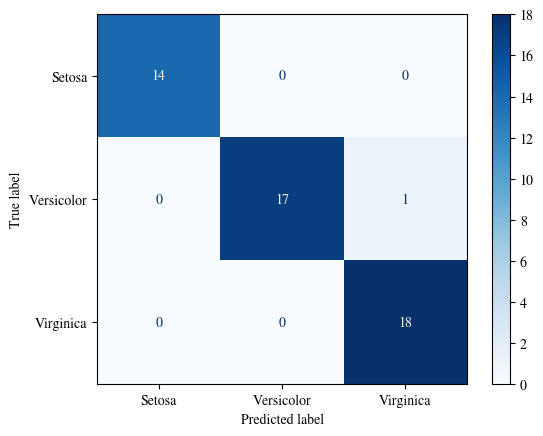

In [40]:
def modified_discriminant_function(x, i):  # Modified for equal priors
    """Gaussian discriminant function"""
    return -0.5 * np.log(np.linalg.det(covs[i])) - 0.5 * (
        x - means[i]
    ).T @ np.linalg.inv(covs[i]) @ (x - means[i])

# Testing
y_pred = np.zeros(len(y_test))

for i in range(len(y_test)):
    x = X_test[i]
    g = np.zeros(len(class_ids))
    for j in class_ids:
        g[j - 1] = discriminant_function(x, j)
    y_pred[i] = np.argmax(g) + 1  # +1 because class_ids start from 1

print("y_pred:\n", y_pred)
print("\ny_test:\n", y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_display.plot(cmap=plt.cm.Blues)
plt.savefig("mod_confusion_matrix.pdf", bbox_inches="tight", dpi=300)
plt.show()

### **Task 2: Multivariate Gaussian Classifier**

Using US CDC data of weekly flu estimates over a year, perform multivariate 
regression (in Matlab $\textbf{load flu}$). This data comprises weekly flu estimates of nine US 
regions (column-2 to 10). Column-1 is the date and last column (WtdILI) is the CDC’s 
national estimate, take this as label $\mathbf{r}$. Since there are nine regions against each date, 
this is d = 9 dimensional data. Visualize data as given in the manual.

1. Save .mat file for flu from Matlab to work in Python
2. Find the parameters $w_j$, $j = 1, 2, \ldots, 9$ for the estimator

$$ g(x \mid w) = w_0 + w_1 x_1^t + w_2 x_2^t + \cdots + w_d x_d^t.$$

3. Observe the structure of $g(x \mid w)$ which should be [N x 1].
4. Plot both $g(x \mid w)$ and label vector $\mathbf{r}$ on the same figure to compare.

**Visualize data as given in the manual.**

We can use the following code to save the .mat file for flu from Matlab to work in Python. Moreover, we also save the data as a .csv file to get the column names and visualize the data in Python.

```matlab
load flu;
Y = double(flu(:,2:end-1));
[n,d] = size(Y);
x = flu.WtdILI;
figure;
regions = flu.Properties.VarNames(2:end-1);
plot(x,Y,'x')
legend(regions,'Location','NorthWest')
% Export files
savemat = [x Y];
save("flu_data.mat", "savemat")
t = dataset2table(flu);
writetable(t, "flu_data.csv")
```

In [41]:
# US CDC Flu data
data = pd.read_csv("flu_data.csv")
data.head()

,Date,NE,MidAtl,ENCentral,WNCentral,SAtl,ESCentral,WSCentral,Mtn,Pac,WtdILI
0,10/9/2005,0.970,1.025,1.232,1.286,1.082,1.457,1.100,0.981,0.971,1.182
1,10/16/2005,1.136,1.060,1.228,1.286,1.146,1.644,1.123,0.976,0.917,1.220
2,10/23/2005,1.135,1.172,1.278,1.536,1.274,1.556,1.236,1.102,0.895,1.310
3,10/30/2005,1.520,1.489,1.576,1.794,1.590,2.252,1.612,1.321,1.082,1.343
4,11/6/2005,1.365,1.394,1.530,1.825,1.620,2.059,1.471,1.453,1.118,1.586


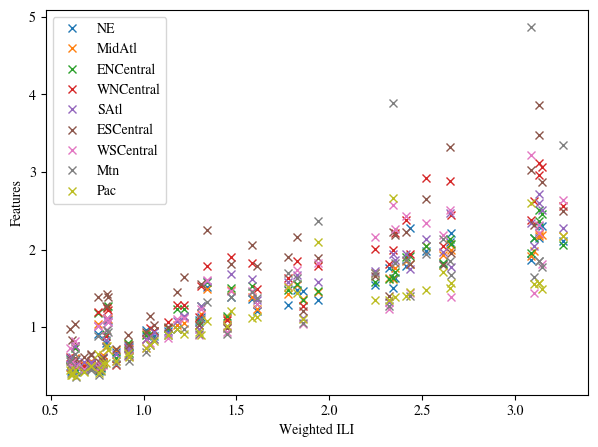

In [42]:
# Separating data into label r and features X
X_df = data.iloc[:, 1:-1]
r_df = data["WtdILI"]
regions = X_df.columns
N, d = X_df.shape

# Plotting
plt.figure(figsize=(7, 5))
plt.plot(r_df, X_df, "x")
plt.xlabel("Weighted ILI")
plt.ylabel("Features")
plt.legend(regions)
plt.savefig("flu_data.pdf", bbox_inches="tight", dpi=300)
plt.show()

**Save .mat file for UC CDC Flu Data from MATLAB to work in Python.**

The following MATLAB code can be used to save the .mat file for UC CDC Flu Data from MATLAB to work in Python.

```matlab
savemat = [x Y];
save("flu_data.mat", "savemat")
```

where `x` and `Y` are the variables in MATLAB workspace as per the manual.

In [43]:
# Multivariate linear regression
data = loadmat("flu_data.mat")["savemat"]
X = data[:, 1:]  # 52x9
r = data[:, 0]  # 52x1

print("X shape:", X.shape)
print("r shape:", r.shape)

X shape: (52, 9)
r shape: (52,)


**Find the parameters $w_j$, $j = 1, 2, \ldots, 9$ for the estimator**

$$ g(x \mid w) = w_0 + w_1 x_1^t + w_2 x_2^t + \cdots + w_d x_d^t.$$

To find the parameters $w_j$, $j = 1, 2, \ldots, 9$ for the estimator, we need to minimize the sum of squared errors (SSE) between the estimated values and the actual values. For that, we need to write our matrices as:

$$\mathbf{X} = \begin{bmatrix} 1 & x_{11} & x_{12} & \cdots & x_{1d} \\ 1 & x_{21} & x_{22} & \cdots & x_{2d} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_{N1} & x_{N2} & \cdots & x_{Nd} \end{bmatrix}, \: \mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \\ \vdots \\ w_d \end{bmatrix}, \: \mathbf{r} = \begin{bmatrix} r_1 \\ r_2 \\ \vdots \\ r_N \end{bmatrix}.$$

Note that we need to append a column of ones to the data matrix $\mathbf{X}$ to account for the bias term $w_0$.

After that, we can solve for the least squared solution using the following equation

$$\mathbf{w} = (\mathbf{X}^TX)^{-1}\mathbf{X}^T\mathbf{r}.$$

In [44]:
# Append a column of ones to X
X_prime = np.hstack((np.ones((N, 1)), X))
print("X shape:", X_prime.shape)

# Estimating parameters
w = np.linalg.inv(X_prime.T @ X_prime) @ X_prime.T @ r  # Moore-Penrose pseudoinverse

print("\nw shape:", w.shape)
print("w:\n", w)

X shape: (52, 10)

w shape: (10,)
w:
 [-0.00485246  0.98435106  0.57276929 -1.43543044  0.49793484  0.9254393
 -0.19997715 -0.37716256  0.2357128   0.05934519]


**Observe the structure of g(x|w) which should be [N x 1].**

In [45]:
# Testing
g = w[0] + X @ w[1:]  # Linear regression
g = g.reshape(-1, 1)  # 52x1

print("\ng(x|w) shape:", g.shape)


g(x|w) shape: (52, 1)


**Plot both $g(x \mid w)$ and label vector $\mathbf{r}$ on the same figure to compare.**

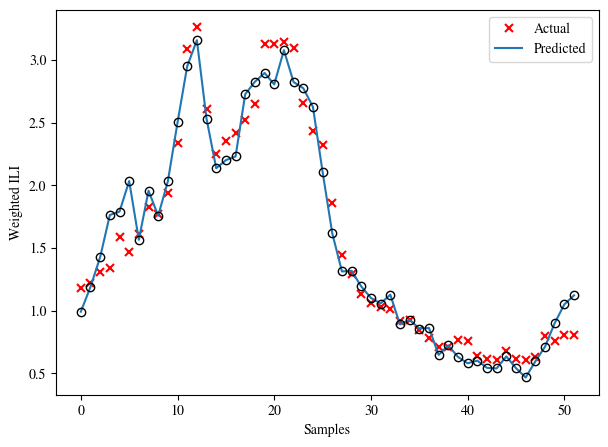

In [46]:
# Plotting
plt.figure(figsize=(7, 5))
plt.plot(r, "x", color="red", markeredgewidth=1.5)
plt.plot(g, "-")
plt.plot(g, "o", color="black", markerfacecolor="none")
# for i in range(d):
#     plt.plot(r, X[:, i], "x", label=regions[i])
#     plt.plot(g, X[:, i], "ko", label=regions[i], markerfacecolor="none")
#     plt.show()
plt.legend(["Actual", "Predicted"])
plt.xlabel("Samples")
plt.ylabel("Weighted ILI")
plt.savefig("flu_data_pred.pdf", bbox_inches="tight", dpi=300)
plt.show()